In [73]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
import logging

logger = logging.getLogger()
logger.handlers.clear()

# format
formatter = logging.Formatter('[%(asctime)s] [%(levelname)s] %(message)s')

# add stream handler
handler = logging.StreamHandler(sys.stdout)                             
handler.setFormatter(formatter)
logger.addHandler(handler)

# enable all logging level
logger.setLevel(logging.INFO)

In [75]:
import os
os.environ['OKFP_ROOT'] = 'C:/Users/sean9/Downloads/FrontPanelUSB'

Definition for the board.

In [76]:
from ece437.ok import OKFrontPanel

path = "C:/Users/sean9/ECE437/Final/Final.runs/impl_1/final_top.bit"
fp = OKFrontPanel(firmware_path=path)

Start talking to CMV300.

[2022-12-13 20:49:42,915] [INFO] upload firmware 'C:/Users/sean9/ECE437/Final/Final.runs/impl_1/final_top.bit'
[2022-12-13 20:49:43,051] [INFO] reset SPI controller
[2022-12-13 20:49:43,052] [INFO] reset CMV300 sequencer
[2022-12-13 20:49:43,057] [INFO] wait_sys_ready TRUE
[2022-12-13 20:49:43,057] [INFO] serial=1911000P3V
[2022-12-13 20:49:43,074] [INFO] .. [acquired]
[2022-12-13 20:49:43,075] [INFO] wait_sys_ready TRUE
(488, 648)
[2022-12-13 20:49:43,119] [INFO] .. [acquired]
[2022-12-13 20:49:43,120] [INFO] wait_sys_ready TRUE
(488, 648)
[2022-12-13 20:49:43,165] [INFO] .. [acquired]
[2022-12-13 20:49:43,166] [INFO] wait_sys_ready TRUE
(488, 648)
[2022-12-13 20:49:43,210] [INFO] .. [acquired]
[2022-12-13 20:49:43,211] [INFO] wait_sys_ready TRUE
(488, 648)
[2022-12-13 20:49:43,258] [INFO] .. [acquired]
[2022-12-13 20:49:43,259] [INFO] wait_sys_ready TRUE
(488, 648)
[2022-12-13 20:49:43,305] [INFO] .. [acquired]
[2022-12-13 20:49:43,306] [INFO] wait_sys_ready TRUE
(488, 648)
[2022-12-

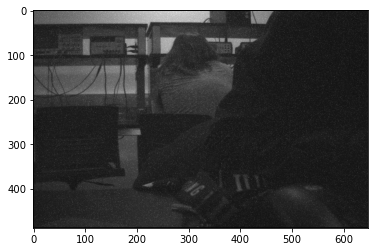

In [81]:
from ece437.spi import SPIController
from ece437.sensor import CMV300
import matplotlib.pyplot as plt
import time
import numpy as np
from ece437.presets import CMV300_SPI_ENDPOINTS, CMV300_DATA_ENDPOINTS

spi = SPIController(fp, CMV300_SPI_ENDPOINTS)
camera = CMV300(fp, spi, CMV300_DATA_ENDPOINTS)

with fp, spi, camera:
    logger.info(f"serial={fp.serial_number}")
    
    for _ in range(10):
        im = camera.get_image()
        time.sleep(0.02) # 50FPS

    fig, ax = plt.subplots(1, 1)
    ax.imshow(im, cmap='gray')
    ax.axis('tight')
    plt.show()